<a href="https://colab.research.google.com/github/institutohumai/cursos-python/blob/master/MachineLearning/9_SeriesDeTiempo/ejercicios/ejercicios.ipynb"> <img src='https://colab.research.google.com/assets/colab-badge.svg' /> </a>
<div align="center"> Recordá abrir en una nueva pestaña </div>

# Series de Tiempo

## Dataset: Flujo Vehicular por Unidades de Peaje AUSA

**Podés descargar el dataset [aquí](https://unket.s3.sa-east-1.amazonaws.com/data/flujo-vehicular-2017_2021_illia.csv). Deberás descargar -  al menos para comenzar - el archivo "flujo-vehicular-2017_2021_illia.csv". Los datasets originales los podés encontrar [aquí](https://data.buenosaires.gob.ar/dataset/flujo-vehicular-por-unidades-de-peaje-ausa). Nosotros ya hicimos un preprocesamiento para que sea más sencillo trabajar con los dataset durante la clase. Si querés ver cómo es ese preprocesamiento, podés mirar el notebook "PreproDatasets.ipynb".**

En este notebook te dejamos unas celdas para que puedas comenzar a trabajar con este dataset. También te dejamos algunas propuestas para que explores. ¡No te preocupes si no llegas a probarlas todas durante la clase!

Las secciones del notebook son las siguientes:

1. Exploración de datos
1. Objetivos del análisis
1. Componentes de la serie
1. Predicción a Futuro
1. Para pensar, investigar y, opcionalmente, implementar

#### Bibliografía recomendada

El análisis que haremos es muy similar al que se encuentra en el [Python Data Science Handbook](https://jakevdp.github.io/PythonDataScienceHandbook/) de Jake VanderPlas sobre el dataset de pasos de bicicletas en el Puente Fremont de Seattle, EEUU. Recomendamos las secciones "Working with Time Series" e "In Depth: Linear Regression". También, recomendamos chusmear el libro "Interpretable Machine Learning", de Christoph Molnar, en particular la sección "5.1 Linear Regression", donde pueden encontrar otro ejemplo similar.


## 1. Exploración de datos

Dedícale un buen tiempo a hacer un Análisis Exploratorio de Datos. Elige preguntas que creas que puedas responder con este dataset. Por ejemplo, ¿Cuáles son los días y horarios de mayor tráfico? También, puedes estudiar autocorrelaciones, resampleos, etc. ¿La serie posee valores atípicos? Si es así, interpreta, si es necesario con información auxiliar. 

Nosotros te dejamos unas celdas para comenzar.


In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import datetime

In [2]:
data = pd.read_csv('https://unket.s3.sa-east-1.amazonaws.com/data/flujo-vehicular-2017_2021_illia.csv', 
                   parse_dates = [1])
data.head()

,periodo,fecha,hora_inicio,estacion,sentido,tipo_vehiculo,forma_pago,cantidad_pasos
0,2017,2017-01-01,0,illia,Centro,Liviano,no cobrado,252
1,2017,2017-01-01,0,illia,Centro,Liviano,efectivo,1
2,2017,2017-01-01,0,illia,Centro,Liviano,telepase,100
3,2017,2017-01-01,0,illia,Centro,Pesado,telepase,2
4,2017,2017-01-01,0,illia,Centro,Pesado,telepase,1


Combinamos la columna `fecha` y `hora_inicio`,


In [3]:
data['fecha'] = pd.to_datetime(data.fecha) + pd.to_timedelta(data.hora_inicio, unit = 'h')
data.head()

,periodo,fecha,hora_inicio,estacion,sentido,tipo_vehiculo,forma_pago,cantidad_pasos
0,2017,2017-01-01,0,illia,Centro,Liviano,no cobrado,252
1,2017,2017-01-01,0,illia,Centro,Liviano,efectivo,1
2,2017,2017-01-01,0,illia,Centro,Liviano,telepase,100
3,2017,2017-01-01,0,illia,Centro,Pesado,telepase,2
4,2017,2017-01-01,0,illia,Centro,Pesado,telepase,1


Para simplificar el análisis, vamos a sumar la `cantidad_pasos` a lo largo de todas las formas de pago y tipos de vehículo. Solamente vamos a separar por `sentido`.

In [4]:
data_reducida = data.groupby(['fecha', 'sentido']).cantidad_pasos.sum()
data_reducida = data_reducida.reset_index()
data_reducida

,fecha,sentido,cantidad_pasos
0,2017-01-01 00:00:00,Centro,356
1,2017-01-01 00:00:00,Provincia,242
2,2017-01-01 01:00:00,Centro,1271
3,2017-01-01 01:00:00,Provincia,951
4,2017-01-01 02:00:00,Centro,1537
...,...,...,...
87510,2021-12-31 21:00:00,Provincia,897
87511,2021-12-31 22:00:00,Centro,326
87512,2021-12-31 22:00:00,Provincia,274
87513,2021-12-31 23:00:00,Centro,164


Llevamos el DataFrame a una forma un poquito más cómoda, pivoteando la tabla en la columna `sentido`.

In [5]:
data_reducida = data_reducida.pivot_table(index = 'fecha',columns=['sentido'], values='cantidad_pasos')
data_reducida.head()

sentido,Centro,Provincia
fecha,,
2017-01-01 00:00:00,356.0,242.0
2017-01-01 01:00:00,1271.0,951.0
2017-01-01 02:00:00,1537.0,1095.0
2017-01-01 03:00:00,1074.0,706.0
2017-01-01 04:00:00,442.0,352.0


In [6]:
data_reducida.reset_index(inplace = True)
data_reducida.head()

sentido,fecha,Centro,Provincia
0,2017-01-01 00:00:00,356.0,242.0
1,2017-01-01 01:00:00,1271.0,951.0
2,2017-01-01 02:00:00,1537.0,1095.0
3,2017-01-01 03:00:00,1074.0,706.0
4,2017-01-01 04:00:00,442.0,352.0


In [7]:
data_reducida = data_reducida.rename_axis(None, axis=1) # Para sacarle nombre `sentido` al indice
data_reducida.head()

,fecha,Centro,Provincia
0,2017-01-01 00:00:00,356.0,242.0
1,2017-01-01 01:00:00,1271.0,951.0
2,2017-01-01 02:00:00,1537.0,1095.0
3,2017-01-01 03:00:00,1074.0,706.0
4,2017-01-01 04:00:00,442.0,352.0


Veamos si hay valores faltantes

In [8]:
data_reducida.isna().sum()

fecha         0
Centro       90
Provincia    21
dtype: int64

Y que no falten fechas

In [9]:
data_reducida.fecha.diff().value_counts()

0 days 01:00:00    43809
0 days 02:00:00        2
0 days 10:00:00        1
Name: fecha, dtype: int64

Bien, hay muy pocos valores y fechas faltantes. En general, está bueno agregar las fechas que falten y, a veces, imputar valores, pero por hoy vamos a obviarlo.

Sumamos una columna `Total`

In [10]:
data_reducida['Total'] = data_reducida['Centro'] + data_reducida['Provincia']

Y graficamos

<AxesSubplot:xlabel='fecha'>

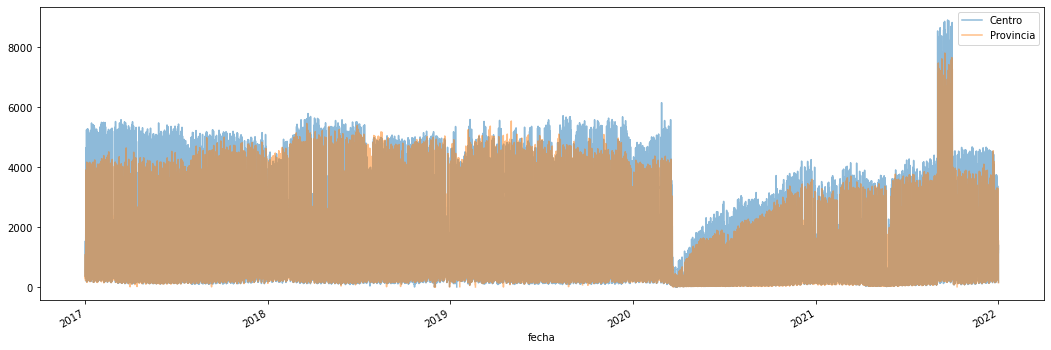

In [11]:
data_reducida.plot(x = 'fecha', y = ['Centro', 'Provincia'], alpha = 0.5, figsize = (18,6))

La visualización está un poco saturada. Sin embargo, se llegan a ver algunas características sobresalientes. ¿Cuáles son?

Veamos más de cerca algunos días individuales. Antes de correr la serie, anticipa lo que esperas ver, en particular en cada *sentido* del tránsito.

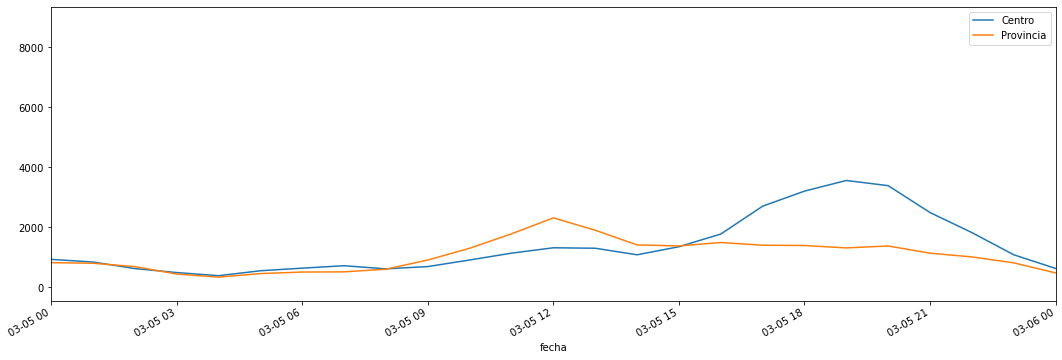

In [12]:
dia = datetime.datetime(2017,3,5,0,0) # un domingo. ¿qué pasa si sumás un día?

data_reducida.plot(x = 'fecha', y = ['Centro', 'Provincia'], figsize = (18,6))
plt.xlim(dia,dia + datetime.timedelta(days = 1))
plt.show()

**Ejercicio 1:** Podemos resamplear para obtener una visualización un poco más amigable. Para ello, utiliza la función `resample` de Pandas para obtener la cantidad de pasos **diarios**. Y grafica.

In [15]:
diario = data_reducida.resample('D',on='fecha').sum()
diario.reset_index(inplace = True)
diario.head()

,fecha,Centro,Provincia,Total
0,2017-01-01,25393.0,20085.0,45478.0
1,2017-01-02,48286.0,41003.0,89289.0
2,2017-01-03,50276.0,42326.0,92602.0
3,2017-01-04,52077.0,43736.0,95813.0
4,2017-01-05,54796.0,45248.0,100044.0


Grafiquemos.

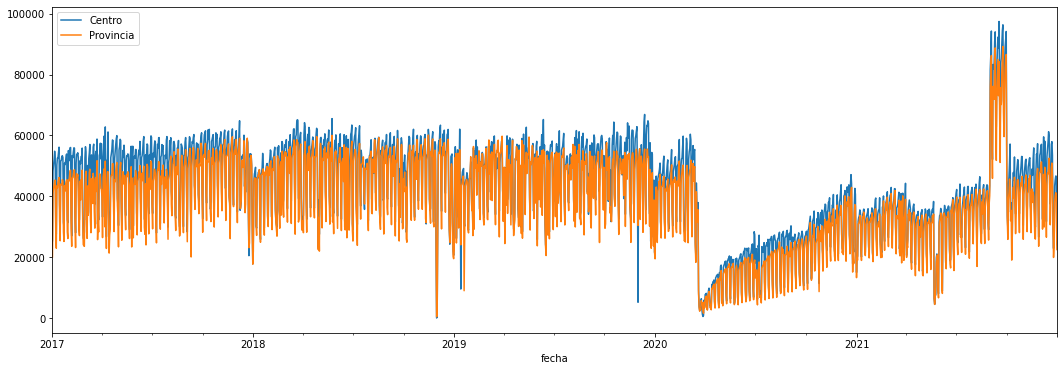

In [17]:
diario.plot(x = 'fecha', y = ['Centro', 'Provincia'],figsize = (18,6))
plt.show()

**Ejercicio 2:** Utilizando la función `groupby` de Pandas, obtén el tráfico promedio **por hora**. Te puede ser útil el comando `data_reducida.fecha.dt.time`.

In [27]:
data_reducida.fecha.dt.time.values

array([datetime.time(0, 0), datetime.time(1, 0), datetime.time(2, 0), ...,
       datetime.time(21, 0), datetime.time(22, 0), datetime.time(23, 0)],
      dtype=object)

In [34]:
data_por_hora = data_reducida.groupby(data_reducida.fecha.dt.time).mean()
data_por_hora.reset_index(inplace = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24 entries, 0 to 23
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   fecha      24 non-null     object 
 1   Centro     24 non-null     float64
 2   Provincia  24 non-null     float64
 3   Total      24 non-null     float64
dtypes: float64(3), object(1)
memory usage: 896.0+ bytes


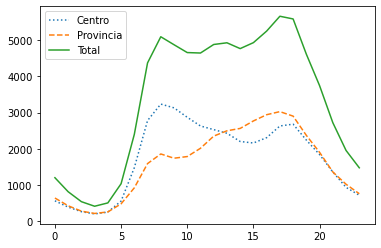

In [35]:
data_por_hora.plot(style=[':', '--', '-']);

**Ejercicio 3:** De la misma forma, obtén el tráfico por día. Pista: `data_reducida.fecha.dt.dayofweek`.

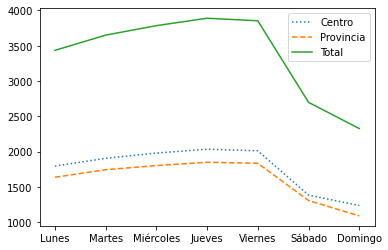

In [38]:
data_por_dia = data_reducida.groupby(data_reducida.fecha.dt.dayofweek).mean()
data_por_dia.index = ['Lunes', 'Martes', 'Miércoles', 'Jueves', 'Viernes', 'Sábado', 'Domingo']
data_por_dia.plot(style=[':', '--', '-']);


**Ejercicio 4:** Combina ambos análisis para obtener el gráfico del tráfico por hora para los días de la semana y los días de fin de semana. Te dejamos algunas pistas.

In [39]:
fin_de_semana = np.where(data_reducida.fecha.dt.dayofweek < 5, 'Semana', 'Fin de semana')
fin_de_semana

array(['Fin de semana', 'Fin de semana', 'Fin de semana', ..., 'Semana',
       'Semana', 'Semana'], dtype='<U13')

In [45]:
data_por_hora = data_reducida.groupby([fin_de_semana,data_reducida.fecha.dt.time]).mean()
data_por_hora

Centro    Provincia        Total
              fecha                                          
Fin de semana 00:00:00   716.915222   814.013436  1532.396917
              01:00:00   583.619691   653.654511  1239.453668
              02:00:00   416.942085   461.840691   880.249035
              03:00:00   293.148649   311.817308   605.335907
              04:00:00   293.169557   296.134357   589.714836
              05:00:00   492.835907   445.715931   939.129344
              06:00:00   745.972973   601.301344  1349.092664
              07:00:00  1018.868726   803.774566  1824.346228
              08:00:00  1218.895753  1025.832692  2247.359768
              09:00:00  1331.332046  1295.137066  2629.007767
              10:00:00  1430.048263  1592.370656  3024.213592
              11:00:00  1562.714286  1965.625483  3528.951456
              12:00:00  1752.507722  2259.240385  4016.963250
              13:00:00  1681.625483  2043.351923  3729.675048
              14:00:00  1493.447876  1685.225000  3182.843327
              15:00:00  1611.054054  1636.900000  3252.108317
              16:00:00  1902.552987  1677.967308  3584.826255
              17:00:00  2208.481696  1642.526923  3855.951737
              18:00:00  2382.225434  1607.507692  3995.040541
              19:00:00  2417.545279  1525.266795  3946.198459
              20:00:00  2193.329480  1456.938580  3653.175337
              21:00:00  1702.878613  1208.982726  2913.934489
              22:00:00  1151.273077   984.422265  2135.655769
              23:00:00   860.423077   798.765835  1659.153846
Semana        00:00:00   498.966232   568.485802  1067.754224
              01:00:00   309.999233   332.551036   642.735023
              02:00:00   199.874137   201.944785   401.955487
              03:00:00   162.101305   172.030675   334.232540
              04:00:00   232.088258   237.255368   469.481197
              05:00:00   579.675365   491.157975  1071.087490
              06:00:00  1767.226994  1048.275307  2815.502301
              07:00:00  3479.603528  1903.052107  5384.112730
              08:00:00  4035.961656  2187.684291  6225.312117
              09:00:00  3846.333589  1915.222989  5762.986963
              10:00:00  3442.019939  1861.170115  5304.590491
              11:00:00  3052.875000  2033.272031  5087.669479
              12:00:00  2837.750767  2385.729502  5225.297546
              13:00:00  2725.325153  2677.498084  5404.871166
              14:00:00  2482.643405  2912.258238  5397.125000
              15:00:00  2377.005368  3220.390038  5599.853528
              16:00:00  2468.056748  3444.642146  5915.332055
              17:00:00  2797.955487  3578.177011  6381.310054
              18:00:00  2798.308519  3418.138697  6221.391404
              19:00:00  2168.996163  2707.201533  4879.927859
              20:00:00  1697.942396  2078.296552  3780.487711
              21:00:00  1222.915515  1419.222222  2645.252688
              22:00:00   846.091398  1033.173313  1880.721966
              23:00:00   658.135177   741.050652  1400.128363

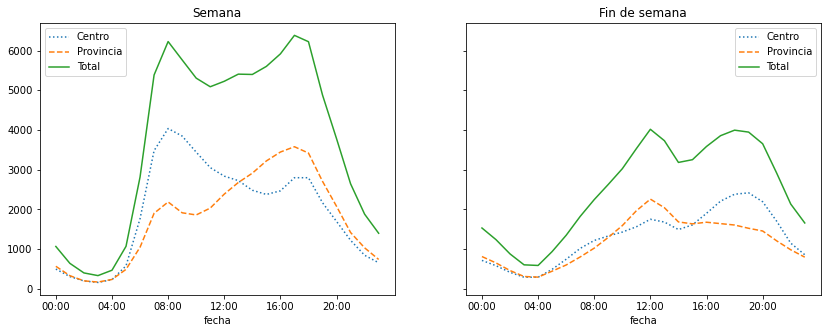

In [47]:
ticks_por_hora = 4 * 60 * 60 * np.arange(6)

fig, ax = plt.subplots(1, 2, figsize=(14, 5),sharey=True)

data_por_hora.loc['Semana'].plot(ax=ax[0], title='Semana',
                           xticks=ticks_por_hora, style=[':', '--', '-'])
data_por_hora.loc['Fin de semana'].plot(ax=ax[1], title='Fin de semana',
                           xticks=ticks_por_hora, style=[':', '--', '-']);



¿Se te ocurre algo más que te gustaría explorar?

In [ ]:
# HAZLO AQUI SI ES EL CASO

## 2. Objetivos del análisis

Piensa algunos posibles objetivos de este análisis. ¿Qué partes interesadas pueden haber en el análisis de un dataset de estas características? Piensa también en aplicaciones similares pero de otros ámbitos.

COMPLETAR

## 3. Componentes de la serie

Utilizando Prophet, obtén las componentes de la serie para el Total de pasos. Observa qué ocurre si utilizas los datos con resolución horaria y los datos con resolución diaria. ¿Qué componente se agrega? También, explora a mano distintos argumentos del modelo.

Para resolver esta sección, puedes utilizar celdas de los materiales asincrónicos. No te preocupes por ahora en separar los datos en *train* y *test*.

**Nota:** En Colab la librería se llama *fbprophet*, mientras que localmente *prophet*.

In [48]:
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import plot_plotly

In [51]:
data_a_descomponer

,fecha,Centro,Provincia,Total
0,2017-01-01 00:00:00,356.0,242.0,598.0
1,2017-01-01 01:00:00,1271.0,951.0,2222.0
2,2017-01-01 02:00:00,1537.0,1095.0,2632.0
3,2017-01-01 03:00:00,1074.0,706.0,1780.0
4,2017-01-01 04:00:00,442.0,352.0,794.0
...,...,...,...,...
43808,2021-12-31 19:00:00,1257.0,1423.0,2680.0
43809,2021-12-31 20:00:00,1408.0,1557.0,2965.0
43810,2021-12-31 21:00:00,901.0,897.0,1798.0
43811,2021-12-31 22:00:00,326.0,274.0,600.0


In [58]:
data_a_descomponer = data_reducida.copy() # data_reducida o diario
data_a_descomponer.rename(columns={'fecha':'ds','Total':'y'}, inplace = True)

In [60]:
# instanciamos modelo
m = Prophet()

# fiteamos el modelo
m.fit(data_a_descomponer)

/home/bombi/miniconda3/envs/ml/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -1818.1


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       80572.1    0.00426385       1367.98           1           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199         80832     0.0204519       2850.06           1           1      231   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299         80970    0.00160482       694.939           1           1      347   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399         81026    0.00343966       614.731      0.8861      0.8861      455   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       81052.5     0.0270642       3679.57      0.2591           1      566   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     599     

In [61]:
# para graficar, hacemos predict
forecast_train = m.predict(data_a_descomponer)

/home/bombi/miniconda3/envs/ml/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/bombi/miniconda3/envs/ml/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


In [62]:
forecast_train.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2017-01-01 00:00:00,3745.173038,-1641.659710,1657.803106,3745.173038,3745.173038,-3793.829012,-3793.829012,-3793.829012,-2120.904971,...,-1180.319630,-1180.319630,-1180.319630,-492.604411,-492.604411,-492.604411,0.0,0.0,0.0,-48.655974
1,2017-01-01 01:00:00,3745.344228,-1943.567152,1298.609528,3745.344228,3745.344228,-4063.965094,-4063.965094,-4063.965094,-2373.856984,...,-1196.423331,-1196.423331,-1196.423331,-493.684778,-493.684778,-493.684778,0.0,0.0,0.0,-318.620865
2,2017-01-01 02:00:00,3745.515418,-2414.987095,760.398589,3745.515418,3745.515418,-4529.483144,-4529.483144,-4529.483144,-2827.212389,...,-1207.514719,-1207.514719,-1207.514719,-494.756036,-494.756036,-494.756036,0.0,0.0,0.0,-783.967727
3,2017-01-01 03:00:00,3745.686608,-2749.123224,479.365050,3745.686608,3745.686608,-4906.415798,-4906.415798,-4906.415798,-3197.050818,...,-1213.546810,-1213.546810,-1213.546810,-495.818170,-495.818170,-495.818170,0.0,0.0,0.0,-1160.729191
4,2017-01-01 04:00:00,3745.857797,-2656.340531,594.123306,3745.857797,3745.857797,-4738.798183,-4738.798183,-4738.798183,-3027.416233,...,-1214.510780,-1214.510780,-1214.510780,-496.871169,-496.871169,-496.871169,0.0,0.0,0.0,-992.940385


/home/bombi/miniconda3/envs/ml/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/bombi/miniconda3/envs/ml/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/bombi/miniconda3/envs/ml/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


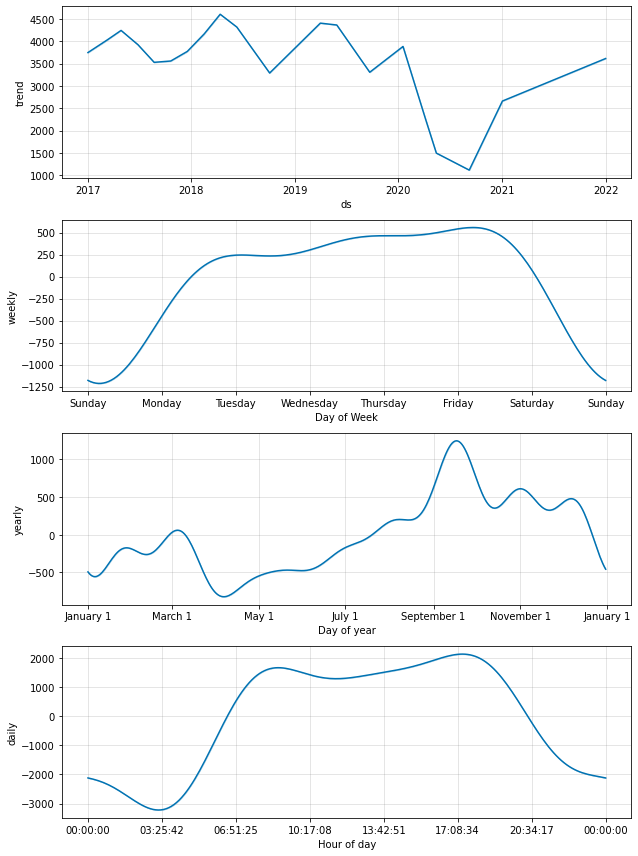

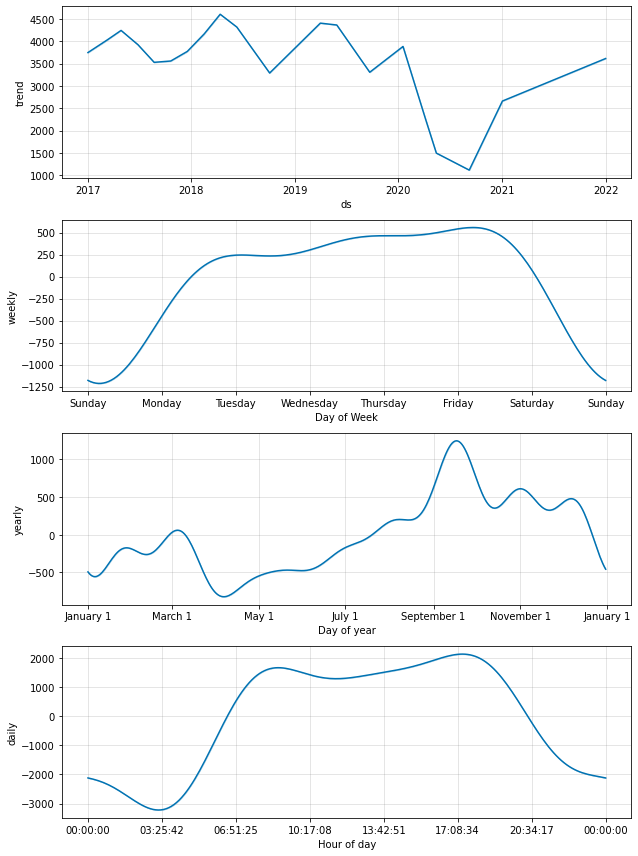

In [63]:
# componentes del forecast
m.plot_components(forecast_train,uncertainty=True)

### 4. Predicción a Futuro

Utilizando Prophet, obtén un modelo para predecir el tráfico Total para el último trimestre del 2019. Empieza por el tráfico diario, luego si tienes tiempo ve a una resolución mayor (horaria). ¿Contra qué modelos de referencia compararías? Si bien estaría bueno que los implementes, aunque sea coméntalos. 

In [130]:
data_a_predecir = pd.date_range('2019-10-01',end='2020-01-01', freq='D') # data_reducida o diario

In [131]:
mask_train = data_a_descomponer.ds < datetime.datetime(2019,10,1) #conveniente para despues
train = data_a_descomponer[mask_train].copy()
train.tail(10)

,ds,Centro,Provincia,y
24051,2019-09-30 14:00:00,2441.0,3184.0,5625.0
24052,2019-09-30 15:00:00,2517.0,3697.0,6214.0
24053,2019-09-30 16:00:00,2720.0,3965.0,6685.0
24054,2019-09-30 17:00:00,3294.0,4256.0,7550.0
24055,2019-09-30 18:00:00,3336.0,4360.0,7696.0
24056,2019-09-30 19:00:00,2091.0,3376.0,5467.0
24057,2019-09-30 20:00:00,1520.0,2468.0,3988.0
24058,2019-09-30 21:00:00,1110.0,1635.0,2745.0
24059,2019-09-30 22:00:00,797.0,1384.0,2181.0
24060,2019-09-30 23:00:00,579.0,680.0,1259.0


In [123]:
mask_test = (data_a_descomponer.ds >= datetime.datetime(2019,10,1)) & \
            (data_a_descomponer.ds < datetime.datetime(2020,1,1))

fechas_a_predecir = data_a_descomponer[mask_test].ds.values

In [139]:
# generamos un dataset futuro para hacer la prediccion
futuro = pd.DataFrame({'ds': data_a_predecir, 'y': np.nan})
futuro.tail()

,ds,y
88,2019-12-28,NaN
89,2019-12-29,NaN
90,2019-12-30,NaN
91,2019-12-31,NaN
92,2020-01-01,NaN


/home/bombi/miniconda3/envs/ml/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -1961.45
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99         38469    0.00122857       139.683      0.6795      0.6795      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       38473.8     0.0247909       220.048       2.067      0.2067      241   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     291         38477   9.71272e-05       233.845   4.842e-07       0.001      400  LS failed, Hessian reset 
     299       38477.2     0.0009074       150.218       2.083      0.2083      410   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     389       38478.1   0.000209528       280.399   1.624e-06       0.001      561  LS failed, Hessian reset 
     399       38478.2   0.000465976       134.889           1           1      571   
    Iter      log pro

/home/bombi/miniconda3/envs/ml/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/bombi/miniconda3/envs/ml/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/bombi/miniconda3/envs/ml/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/bombi/miniconda3/envs/ml/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inst

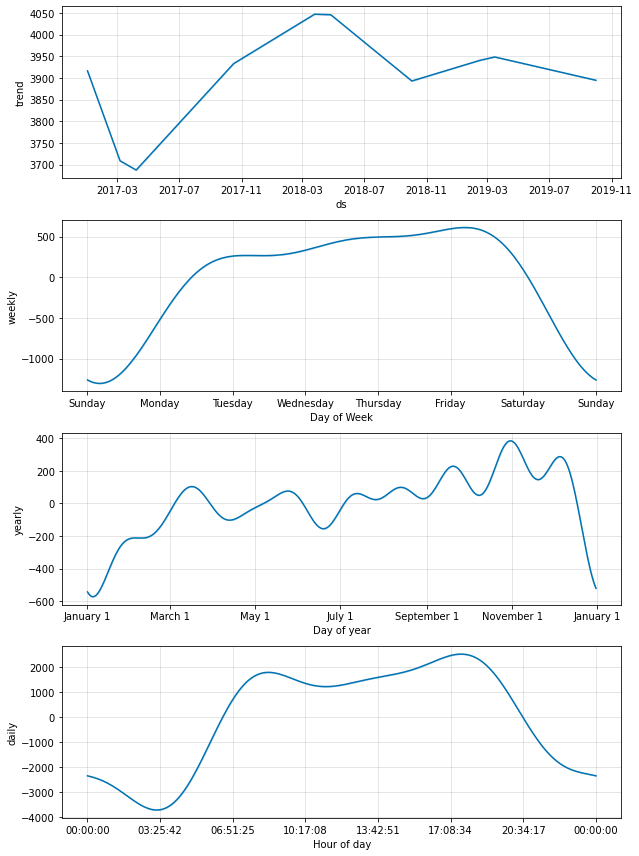

In [140]:
# instanciamos modelo
m = Prophet()

# fiteamos el modelo en TRAIN
m.fit(train)

# predecimos en futuro
forecast = m.predict(futuro)

# para graficar, hacemos predict tambien en train
forecast_train = m.predict(train)

# #unimos los dos DFs para visualizar las dos partes, train-prediccion
forecast_final = pd.concat([forecast_train, forecast])

# #plot componentes del forecast
m.plot_components(forecast_train);

In [141]:
forecast_final.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2017-01-01 00:00:00,3916.180708,-1794.470185,1171.412711,3916.180708,3916.180708,-4156.495369,-4156.495369,-4156.495369,-2349.423391,...,-1263.137845,-1263.137845,-1263.137845,-543.934133,-543.934133,-543.934133,0.0,0.0,0.0,-240.314661
1,2017-01-01 01:00:00,3916.045752,-2085.968077,846.100625,3916.045752,3916.045752,-4492.051985,-4492.051985,-4492.051985,-2665.700576,...,-1281.779110,-1281.779110,-1281.779110,-544.572298,-544.572298,-544.572298,0.0,0.0,0.0,-576.006232
2,2017-01-01 02:00:00,3915.910797,-2575.671650,339.003418,3915.910797,3915.910797,-5071.857773,-5071.857773,-5071.857773,-3231.499583,...,-1295.154858,-1295.154858,-1295.154858,-545.203332,-545.203332,-545.203332,0.0,0.0,0.0,-1155.946976
3,2017-01-01 03:00:00,3915.775841,-3187.663234,-63.796717,3915.775841,3915.775841,-5537.413170,-5537.413170,-5537.413170,-3688.377950,...,-1303.207986,-1303.207986,-1303.207986,-545.827234,-545.827234,-545.827234,0.0,0.0,0.0,-1621.637329
4,2017-01-01 04:00:00,3915.640885,-2766.669719,68.688107,3915.640885,3915.640885,-5326.652548,-5326.652548,-5326.652548,-3474.287742,...,-1305.920802,-1305.920802,-1305.920802,-546.444004,-546.444004,-546.444004,0.0,0.0,0.0,-1411.011663


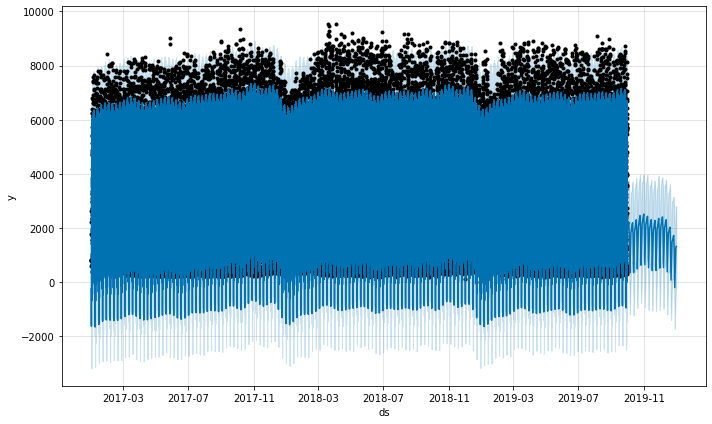

In [142]:
m.plot(forecast_final)
plt.show()

Comparemos contra los datos originales, separando en *train* y *test*. Observa atentamente la *forma* de las predicciones. ¿Notas algo?

(18109.0, 18262.0)

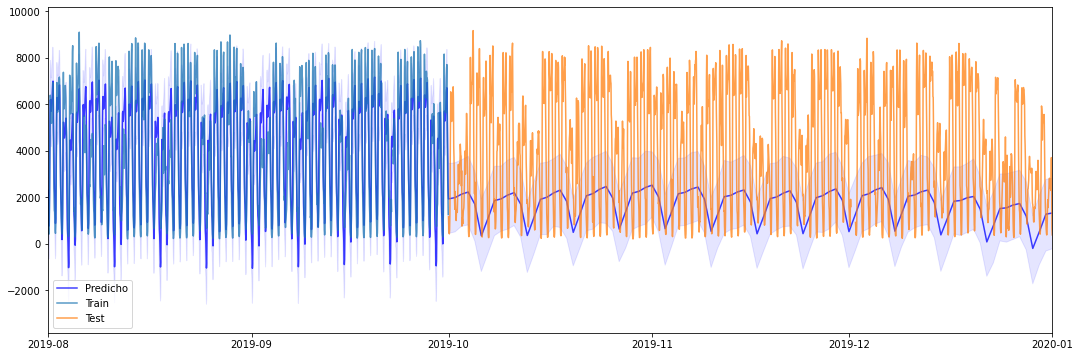

In [143]:
plt.figure(figsize = (18,6))
plt.plot(forecast_final.ds, forecast_final.yhat, alpha = 0.75, 
         label = 'Predicho', color = 'blue')
plt.fill_between(forecast_final.ds, forecast_final.yhat_lower, forecast_final.yhat_upper,
                 alpha = 0.1, color = 'blue' )


plt.plot(data_a_descomponer[mask_train].ds, data_a_descomponer[mask_train].y, alpha = 0.75, label = 'Train')
plt.plot(data_a_descomponer[mask_test].ds, data_a_descomponer[mask_test].y, alpha = 0.75, label = 'Test')

plt.legend()
plt.xlim(datetime.datetime(2019,8,1),datetime.datetime(2020,1,1) )

Con el diario del lunes sabemos que el modelo no va a andar muy bien en el 2020. De todas formas, predice sobre 2020 y observa las predicciones. ¿Hay algo que un pronosticador podría haber hecho en 2019 para anticiparse?¿Siempre se puede predecir?

In [ ]:
mask_2020 = (COMPLETAR) & \
            (COMPLETAR)

fechas_a_predecir = data_a_predecir[COMPLETAR].ds.values

In [ ]:
# generamos un dataset futuro para hacer la prediccion
futuro = pd.DataFrame({'ds': fechas_a_predecir, 'y': np.nan})
futuro.head()

In [ ]:
# predecimos en futuro
forecast = m.COMPLETAR

In [ ]:
plt.figure(figsize = (18,6))
plt.plot(forecast.ds, forecast.yhat, alpha = 0.75, 
         label = 'Predicho', color = 'blue')
plt.fill_between(forecast.ds, forecast.yhat_lower, forecast.yhat_upper,
                 alpha = 0.1, color = 'blue' )

plt.plot(data_a_predecir[mask_2020].ds, data_a_predecir[mask_2020].y, alpha = 0.75, label = '2020')

plt.legend()
plt.show()

## 5. Para pensar, investigar y, opcionalmente, implementar

¿Cómo incorporarías la información sobre tipo de vehículo, forma de pago, sentido, día de la semana, etc.? En lo que respecta a las predicciones, ¿esperas que mejoren o empeoren?